#Title: Correlation Analysis (Pearson / Spearman) for Variable Reduction

#Objective: Evaluate relationships among sales metrics and identify redundant columns to build a simpler and more robust analytical model.

#Methodology (summary):
 
# #Basic data cleaning (types, NaN handling, reasonable filters).

#Pearson correlation (linear) as the main metric.

#Spearman correlation (monotonic) as a comparison.

#Visualization with heatmaps.

#Table of top correlations and reduction suggestions (based on business rules).

In [2]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")      # tamaño de fuente agradable para screenshots
sns.set_palette("crest")

# Carga (ajusta rutas si fuera necesario)
sales    = pd.read_csv("../data/fact_sales.csv")
products = pd.read_csv("../data/dim_product.csv")
stores   = pd.read_csv("../data/dim_store.csv")

# Inspección inicial
display(sales.head(3))
sales.dtypes


,sale_line_id,store_id,product_id,qty_sold,unit_price_usd,line_revenue_usd,order_date
0,500001,30,1488,1,19.91,19.91,2025-04-19
1,500002,40,1221,1,17.55,17.55,2025-04-29
2,500003,50,1370,4,11.90,47.60,2025-06-04


sale_line_id          int64
store_id              int64
product_id            int64
qty_sold              int64
unit_price_usd      float64
line_revenue_usd    float64
order_date           object
dtype: object

We start by looking at 3 rows and their data types; this allows you to quickly detect dtype errors 
 (for example, prices stored as text).



In [3]:
# Fechas tolerantes a errores
sales["order_date"] = pd.to_datetime(
    sales["order_date"], errors="coerce", infer_datetime_format=True
)

# Forzar numéricos con coerción (evita romper por strings, comas, símbolos)
for c in ["qty_sold", "unit_price_usd", "line_revenue_usd"]:
    sales[c] = pd.to_numeric(sales[c], errors="coerce")

# Filtros de calidad razonables
sales = sales[(sales["qty_sold"] > 0) & (sales["unit_price_usd"] > 0)]

# Métrica derivada controlada por nosotros (disminuye riesgo de inconsistencias)
sales["total_revenue_calc"] = sales["qty_sold"] * sales["unit_price_usd"]

# Enriquecer con catálogos para análisis (opcional pero útil para cortes)
df = (sales
      .merge(products, on="product_id", how="left")
      .merge(stores,   on="store_id",   how="left"))

# Vista rápida
df.sample(5, random_state=42)


C:\Users\diego\AppData\Local\Temp\ipykernel_12868\397569834.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  sales["order_date"] = pd.to_datetime(


,sale_line_id,store_id,product_id,qty_sold,unit_price_usd,line_revenue_usd,order_date,total_revenue_calc,sku,product_name,category,unit,avg_unit_cost_usd,store_name,city,state,open_date
47044,547045,40,1419,1,5.99,5.99,2025-04-06,5.99,DRY-1419,Dry Goods Item 1419,Dry Goods,lb,2.42,Miami Wynwood,Miami,FL,2020-11-05
44295,544296,40,1218,2,6.33,12.66,2025-02-11,12.66,BEV-1218,Beverages Item 1218,Beverages,bottle,2.70,Miami Wynwood,Miami,FL,2020-11-05
74783,574784,30,1034,1,9.43,9.43,2025-09-10,9.43,DAI-1034,Dairy Item 1034,Dairy,qt,3.70,Fort Lauderdale,Fort Lauderdale,FL,2023-01-10
70975,570976,60,1313,2,18.00,36.00,2025-04-11,36.00,PRO-1313,Produce Item 1313,Produce,lb,7.42,Lake Worth,Lake Worth,FL,2024-02-14
46645,546646,30,1167,1,5.72,5.72,2025-02-15,5.72,CON-1167,Condiments Item 1167,Condiments,lb,1.68,Fort Lauderdale,Fort Lauderdale,FL,2023-01-10



*_calc as the “source of truth” for totals prevents relying on pre-calculated columns that might be misaligned.

In [4]:
# Excluimos IDs y llaves; nos quedamos con numéricas “analíticas”
ban = {"sale_line_id","store_id","product_id","vendor_id","employee_id"}
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
vars_for_corr = [c for c in num_cols if c not in ban and df[c].notna().sum() > 0]

vars_for_corr


['qty_sold',
 'unit_price_usd',
 'line_revenue_usd',
 'total_revenue_calc',
 'avg_unit_cost_usd']

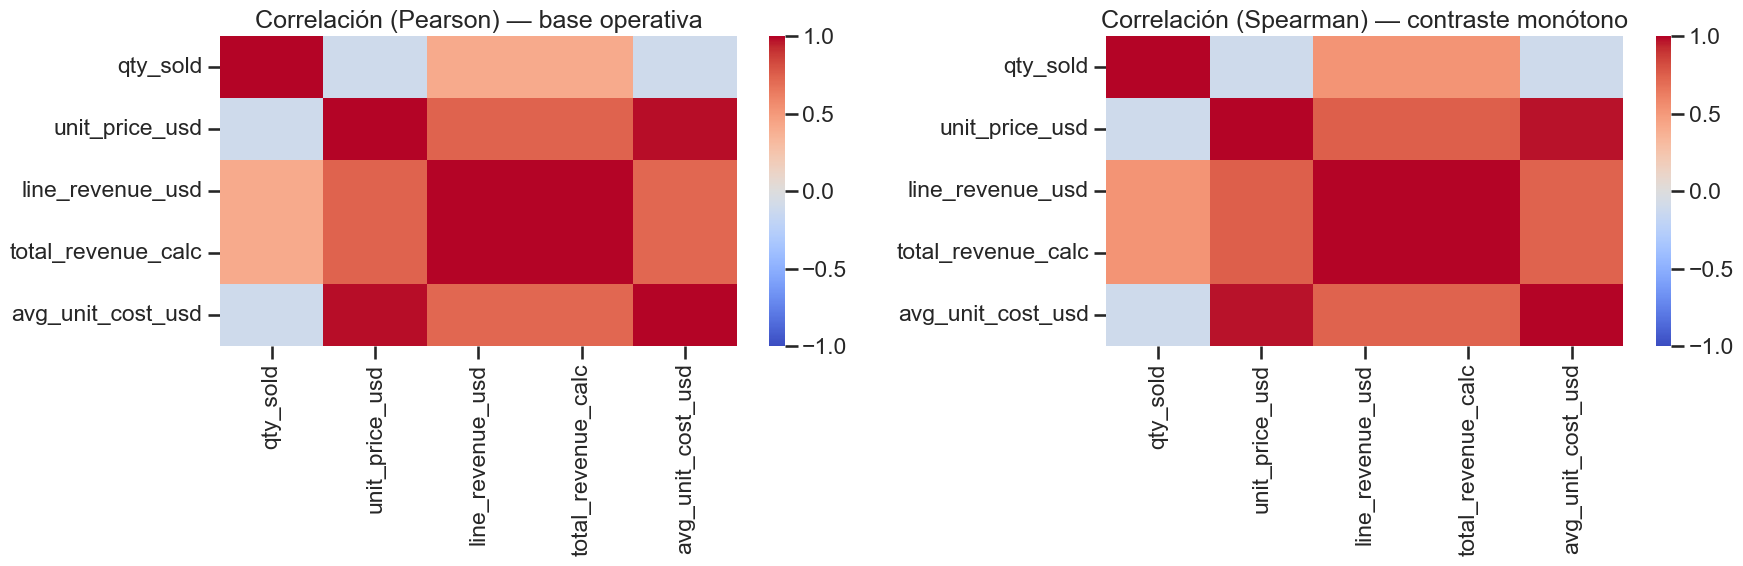

In [5]:
# Pearson = base operativa; Spearman = contraste monótono
corr_pearson  = df[vars_for_corr].corr(method="pearson")
corr_spearman = df[vars_for_corr].corr(method="spearman")

# Heatmaps comparativos
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(corr_pearson,  annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Correlación (Pearson) — base operativa")

sns.heatmap(corr_spearman, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Correlación (Spearman) — contraste monótono")

plt.tight_layout()
plt.show()

# Export opcional (para README o Power BI)
fig.savefig("../docs/corr_sales_pearson_vs_spearman.png", dpi=140, bbox_inches="tight")


Showing both methods once during the EDA demonstrates technical judgment; in production, we stick with Pearson.

A flat table with the top correlations is more scannable for prioritizing decisions (what to review or remove).


In [7]:
def top_correlations(corr_df: pd.DataFrame, k=20) -> pd.DataFrame:
    """
    Convierte la matriz de correlación en una lista ordenada (descendente),
    excluyendo la diagonal y duplicados (triángulo superior).
    """
    c = corr_df.copy()
    # elimina diagonal
    np.fill_diagonal(c.values, np.nan)
    # a lista
    pairs = (c.unstack()
               .dropna()
               .sort_values(ascending=False)
               .reset_index())
    pairs.columns = ["feature_1","feature_2","corr"]
    # quita duplicados (A-B y B-A)
    pairs["key"] = pairs.apply(lambda r: tuple(sorted([r["feature_1"], r["feature_2"]])), axis=1)
    pairs = pairs.drop_duplicates("key").drop(columns="key")
    return pairs.head(k)

print("=== Top correlaciones (Pearson) ===")
top_p = top_correlations(corr_pearson, k=20)
display(top_p)

print("=== Top correlaciones (Spearman) ===")
top_s = top_correlations(corr_spearman, k=20)
display(top_s)

# Export opcional
top_p.to_csv("../docs/top_corr_pearson_sales.csv", index=False)
top_s.to_csv("../docs/top_corr_spearman_sales.csv", index=False)


=== Top correlaciones (Pearson) ===


,feature_1,feature_2,corr
0,total_revenue_calc,line_revenue_usd,1.000000
2,unit_price_usd,avg_unit_cost_usd,0.978538
4,line_revenue_usd,unit_price_usd,0.739220
5,total_revenue_calc,unit_price_usd,0.739220
8,avg_unit_cost_usd,total_revenue_calc,0.721904
9,avg_unit_cost_usd,line_revenue_usd,0.721904
12,total_revenue_calc,qty_sold,0.409370
13,line_revenue_usd,qty_sold,0.409370
16,unit_price_usd,qty_sold,-0.102448
18,qty_sold,avg_unit_cost_usd,-0.104557


=== Top correlaciones (Spearman) ===


,feature_1,feature_2,corr
0,total_revenue_calc,line_revenue_usd,1.000000
2,unit_price_usd,avg_unit_cost_usd,0.974768
4,line_revenue_usd,unit_price_usd,0.755927
6,unit_price_usd,total_revenue_calc,0.755926
8,line_revenue_usd,avg_unit_cost_usd,0.735814
10,avg_unit_cost_usd,total_revenue_calc,0.735814
12,total_revenue_calc,qty_sold,0.530361
14,qty_sold,line_revenue_usd,0.530361
16,unit_price_usd,qty_sold,-0.107157
18,qty_sold,avg_unit_cost_usd,-0.109197


Columns are not removed solely based on high correlation values. For the purposes of this project, variables with correlations above 0.90 will be retained, as the goal is to maintain completeness rather than enforce dimensional reduction.

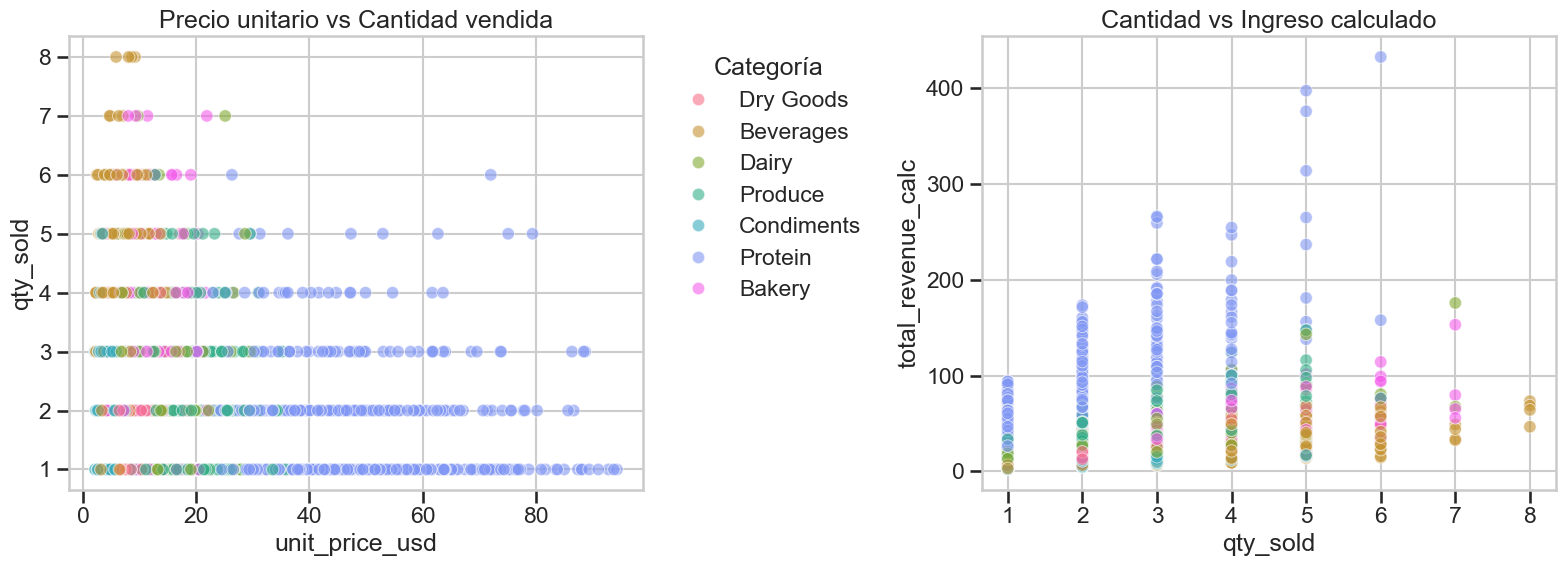

In [8]:
# Muestra controlada para rendimiento
sample = df.sample(min(5000, len(df)), random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.scatterplot(data=sample, x="unit_price_usd", y="qty_sold",
                hue="category", alpha=0.6, ax=axes[0])
axes[0].set_title("Precio unitario vs Cantidad vendida")
axes[0].legend(title="Categoría", bbox_to_anchor=(1.02,1), loc="upper left")

sns.scatterplot(data=sample, x="qty_sold", y="total_revenue_calc",
                hue="category", alpha=0.6, ax=axes[1])
axes[1].set_title("Cantidad vs Ingreso calculado")
axes[1].legend([],[], frameon=False)

plt.tight_layout()
plt.show()

fig.savefig("../docs/scatter_price_qty_revenue.png", dpi=140, bbox_inches="tight")


Conclusions (template):

A strong correlation (|r| ≈ 1) is observed between total_revenue_calc and line_revenue_usd, suggesting that line_revenue_usd can be excluded from the model and recalculated on the fly to minimize inconsistency risks.

The relationship between unit_price_usd and qty_sold shows the expected negative correlation, reflecting price sensitivity. Both variables should be retained due to their explanatory relevance.

Correlations among store- and product-level metrics exhibit variability across categories, indicating that analyses (or models) should be segmented by category.

Next step: Replicate this analysis for fact_purchases and inventory_movements, and consolidate a comprehensive variable dictionary to support both the star schema model and Power BI integration.